In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dts
import pandas as pd
import quandl as Quandl
from lxml import etree
import requests
import fredpy as fp
plt.style.use('classic')
%matplotlib inline

# Covered interest parity

Covered interest parity is a no-arbitrage condition in foreign exchange markets. In terms of US dollars and British pounds, the covered interest parity condition can be expressed as:
    $$
    1+i_{\unicode{x24}}  = (1+i_{\unicode{xA3}}) \cdot \frac{F_{\unicode{x24}/\unicode{xA3}}}{E_{\unicode{x24}/\unicode{xA3}}}
    $$
Where $i_{\unicode{x24}}$ is the risk-free interest rate on dollars, $i_{\unicode{xA3}}$ is the risk-free intrest rate on pounds, 
$E_{\unicode{x24}/\unicode{xA3}}$ is the current spot rate in terms of dollars per pound, and $F_{\unicode{x24}/\unicode{xA3}}$ is the forward exchagne rate. The left-side of the equation is the risk-free return on dollars and the right-side is the risk-free return on pounds expressed in dollars. Equilibrium requires equality between the two returns because otherwise a person could earn risk-free profit by borrowing on one currency and saving in another.

Historical data on forward exchange rates is not readily available for many countries. This program uses data from [Quandl](https://www.quandl.com/) and from the [Federal Reserve Bank of New York](https://www.newyorkfed.org/) to obtain interest, spot exchange, and forward exchange rate data for the purposes of evaluating the covered interest parity condition.  All intrest rates used below are 6-month Libor rates and all forward rates are for transactions to be executed in 6-months and all exchange rates are expressed in terms of US dollars per unit of foreign currency.

* Yen (daily)
* Euro (daily)
* Pound (monthly)
* Swiss franc (monthly)

Note: since the interest rates are expressed in annualized terms, the interest rate terms in the covered interest parity condition must be divided by 2:
    $$
    1+\frac{i_{\unicode{x24}}}{2}  = \left(1+\frac{i_{\unicode{xA3}}}{2} \right) \cdot \frac{F_{\unicode{x24}/\unicode{xA3}}}{E_{\unicode{x24}/\unicode{xA3}}}
    $$
    
This program exports two csv files; one for the daily euro and yen data and another for the monthly pound and franc data:

* cipEuroYenDaily.csv
* cipPoundFrancMonthly.csv

## Daily CIP data from FRBNY

In [15]:
# Function for downloading historical data in .xml format from FRBNY

def download_xml(url,file_name):

    u = requests.get(url)

    with open(file_name, 'wb') as f:
        for chunk in u.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                f.flush()
    f.close()
    
# Function for parsing .xml data and extracting data values and dates
    
def get_data_from_xml(file_name,column_name):
    
    tree = etree.parse(file_name)
    root = tree.getroot()
    dates=[]
    values=[]
    y = root[1][0]
    for i, vals in enumerate(y):
        if i>0:
            try:
                float(vals.getchildren()[1].text)
                dates.append(vals.getchildren()[0].text)
                values.append(float(vals.getchildren()[1].text))
            except:
                print('date with missing value in '+file_name+':',vals.getchildren()[0].text)
    
    frame = pd.DataFrame({column_name:values},index=pd.to_datetime(dates))
    return frame

In [16]:
# Download .xml files from FRBNY

download_xml(url='https://www.newyorkfed.org/medialibrary/media/xml/data/fx/EUR10.xml',file_name = '../xml/euro_spot.xml')
download_xml(url='https://www.newyorkfed.org/medialibrary/media/xml/data/fx/EUR10Forward6.xml',file_name = '../xml/euro_forward.xml')
download_xml(url='https://www.newyorkfed.org/medialibrary/media/xml/data/fx/JPY10.xml',file_name='../xml/yen_spot.xml')
download_xml(url='https://www.newyorkfed.org/medialibrary/media/xml/data/fx/JPY10Forward6.xml',file_name='../xml/yen_forward.xml')

In [17]:
# Create data frames

euro_spot_frame = get_data_from_xml('../xml/euro_spot.xml','euro spot')
euro_forward_frame = get_data_from_xml('../xml/euro_forward.xml','euro forward')
yen_spot_frame = get_data_from_xml('../xml/yen_spot.xml','yen spot')
yen_forward_frame = get_data_from_xml('../xml/yen_forward.xml','yen forward')

euro_rates = pd.concat([euro_spot_frame,euro_forward_frame],axis=1).dropna()
yen_rates = pd.concat([1/yen_spot_frame,1/yen_forward_frame],axis=1).dropna()
rates = pd.concat([yen_rates,euro_rates],axis=1).dropna()

date with missing value in ../xml/euro_forward.xml: 2003-12-30
date with missing value in ../xml/yen_forward.xml: 2003-12-30


In [18]:
# Download interest rate data from Quandl
yen_libor = Quandl.get('FRED/JPY6MTD156N', collapse='daily',authtoken="QqLL1AFCjc31_MVo4qsU")
euro_libor = Quandl.get('FRED/EUR6MTD156N', collapse='daily',authtoken="QqLL1AFCjc31_MVo4qsU")
dollar_libor = pd.DataFrame(fp.series('USD6MTD156N').data)
dollar_libor.index.name = 'DATE'

euro_libor.columns = ['euro interest']
yen_libor.columns = ['yen interest']
dollar_libor.columns = ['dollar interest']

In [19]:
# Organize data into DataFrames
yen_frame = pd.concat([yen_rates,yen_libor,dollar_libor],axis=1).dropna()
euro_frame = pd.concat([euro_rates,euro_libor,dollar_libor],axis=1).dropna()

full_frame = pd.concat([euro_rates,euro_libor,yen_rates,yen_libor,dollar_libor],axis=1).dropna()

# Export data to .csv
full_frame[['euro spot', 'euro forward', 'euro interest', 'yen spot', 'yen forward','yen interest', 'dollar interest']].to_csv('../csv/cip_euro_yen_daily.csv')

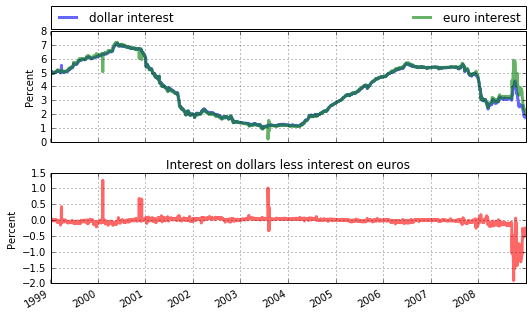

In [20]:
# Construct dollar-denominated return on euros
i_euro = 200*(1+euro_frame['euro interest']/200)*euro_frame['euro forward']/euro_frame['euro spot'] - 200

# Plot
fig = plt.figure(figsize=(7.5, 4.5))
ax = fig.add_subplot(2,1,1)
ax.plot_date(euro_frame.index,euro_frame['dollar interest'],'-',lw=3,alpha = 0.6,label='dollar interest')
ax.plot_date(euro_frame.index,i_euro,'-',lw=3,alpha = 0.6,label='euro interest')
ax.set_ylabel('Percent')
ax.grid()

ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=4, mode="expand", borderaxespad=0.)

ax = fig.add_subplot(2,1,2)
ax.plot_date(euro_frame.index,euro_frame['dollar interest']-i_euro,'-r',lw=3,alpha = 0.6)
ax.set_title('Interest on dollars less interest on euros')
ax.set_ylabel('Percent')
ax.grid()

fig.autofmt_xdate()
plt.tight_layout()
plt.savefig('../png/fig_dollar_euro_cip.png',bbox_inches='tight',dpi=120)

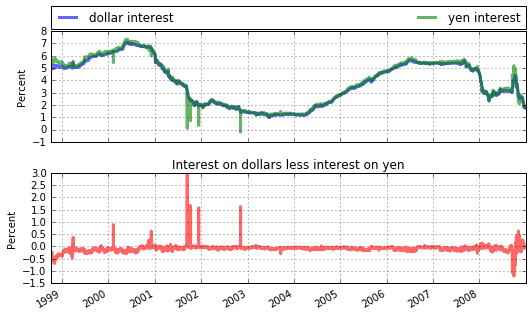

In [21]:
# Construct dollar-denominated return on euros
i_yen = 200*(1+yen_frame['yen interest']/200)*yen_frame['yen forward']/yen_frame['yen spot'] - 200

# Plot
fig = plt.figure(figsize=(7.5, 4.5))
ax = fig.add_subplot(2,1,1)
ax.plot_date(yen_frame.index,yen_frame['dollar interest'],'-',lw=3,alpha = 0.6,label='dollar interest')
ax.plot_date(yen_frame.index,i_yen,'-',lw=3,alpha = 0.6,label='yen interest')
ax.set_ylabel('Percent')
ax.grid()

ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=4, mode="expand", borderaxespad=0.)

ax = fig.add_subplot(2,1,2)
ax.plot_date(yen_frame.index,yen_frame['dollar interest']-i_yen,'-r',lw=3,alpha = 0.6)
ax.set_title('Interest on dollars less interest on yen')
ax.set_ylabel('Percent')
ax.grid()

fig.autofmt_xdate()
plt.tight_layout()
plt.savefig('../png/fig_dollar_yen_cip.png',bbox_inches='tight',dpi=120)

# Monthly CIP data from Quandl

In [22]:
# Download pound data from Quandl and organize
pound_forward = Quandl.get('BOE/XUMADS6', collapse='monthly',trim_start='1994-01-31',authtoken="QqLL1AFCjc31_MVo4qsU")
pound_libor = Quandl.get('BOE/IUMAVSMA', collapse='monthly',trim_start='1994-01-31',authtoken="QqLL1AFCjc31_MVo4qsU")
pound_spot = Quandl.get('BOE/XUMAUSS', collapse='monthly',trim_start='1994-01-31',authtoken="QqLL1AFCjc31_MVo4qsU")
dollar_libor = Quandl.get('BCB/3841', collapse='monthly',trim_start='1994-01-31',authtoken="QqLL1AFCjc31_MVo4qsU")

pound_forward.columns = ['pound forward']
pound_spot.columns = ['pound spot']
pound_libor.columns = ['pound interest']
dollar_libor.columns = ['dollar interest']

pound_frame = pd.concat([pound_forward,pound_spot,pound_libor,dollar_libor],axis=1).dropna()

In [23]:
# Download franc data from Quandl and organize
try:
    franc_forward = Quandl.get('SNB/G3_M1_M', collapse='monthly',trim_start='1994-01-31',authtoken="QqLL1AFCjc31_MVo4qsU")
    dollar_libor = Quandl.get('BCB/3841', collapse='monthly',trim_start='1994-01-31',authtoken="QqLL1AFCjc31_MVo4qsU")
    franc_spot = Quandl.get('BOE/XUMASFD', collapse='monthly',trim_start='1994-01-31',authtoken="QqLL1AFCjc31_MVo4qsU")
    franc_libor = Quandl.get('BCB/3843', collapse='monthly',trim_start='1994-01-31',authtoken="QqLL1AFCjc31_MVo4qsU")

    franc_forward = pd.DataFrame({'franc forward':1/franc_forward['6-month forward rate'].values},index = franc_forward['6-month forward rate'].index)
    franc_spot = 1/franc_spot

    franc_forward.columns = ['franc forward']
    franc_spot.columns = ['franc spot']
    franc_libor.columns = ['franc interest']
    dollar_libor.columns = ['dollar interest']

    franc_frame = pd.concat([franc_forward,franc_spot,franc_libor,dollar_libor],axis=1).dropna()
    
except:
    franc_frame = pd.read_csv('../csv_saved/cip_franc_monthly.csv',index_col=0,parse_dates=True)

In [24]:
# Pull Quandl data together and export to .csv
full_frame = pd.concat([pound_frame,franc_frame],axis=1)

full_frame[['pound spot', 'pound forward', 'pound interest', 'franc spot', 'franc forward','franc interest', 'dollar interest']].to_csv('../csv/cip_pound_franc_monthly.csv')


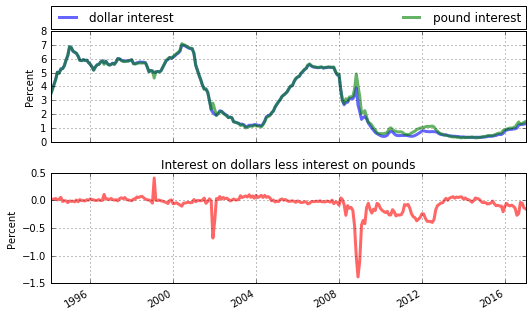

In [25]:
# Construct dollar-denominated return on pounds
i_pound = 200*(1+pound_frame['pound interest']/200)*pound_frame['pound forward']/pound_frame['pound spot'] - 200

# Plot
fig = plt.figure(figsize=(7.5, 4.5))
ax = fig.add_subplot(2,1,1)
ax.plot_date(pound_frame.index,pound_frame['dollar interest'],'-',lw=3,alpha = 0.6,label='dollar interest')
ax.plot_date(pound_frame.index,i_pound,'-',lw=3,alpha = 0.6,label='pound interest')
ax.set_ylabel('Percent')
ax.grid()

ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=4, mode="expand", borderaxespad=0.)

ax = fig.add_subplot(2,1,2)
ax.plot_date(pound_frame.index,pound_frame['dollar interest']-i_pound,'-r',lw=3,alpha = 0.6)
ax.set_title('Interest on dollars less interest on pounds')
ax.set_ylabel('Percent')
ax.grid()

fig.autofmt_xdate()
plt.tight_layout()
plt.savefig('../png/fig_dollar_pound_cip.png',bbox_inches='tight',dpi=120)

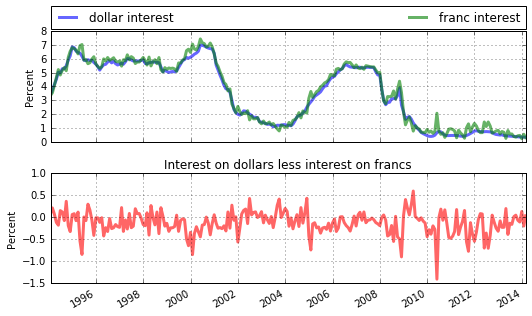

In [26]:
# Construct dollar-denominated return on francs
i_franc = 200*(1+franc_frame['franc interest']/200)*franc_frame['franc forward']/franc_frame['franc spot'] - 200

# Plot
fig = plt.figure(figsize=(7.5, 4.5))
ax = fig.add_subplot(2,1,1)
ax.plot_date(franc_frame.index,franc_frame['dollar interest'],'-',lw=3,alpha = 0.6,label='dollar interest')
ax.plot_date(franc_frame.index,i_franc,'-',lw=3,alpha = 0.6,label='franc interest')
ax.set_ylabel('Percent')
ax.grid()

ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,ncol=4, mode="expand", borderaxespad=0.)

ax = fig.add_subplot(2,1,2)
ax.plot_date(franc_frame.index,franc_frame['dollar interest']-i_franc,'-r',lw=3,alpha = 0.6)
ax.set_title('Interest on dollars less interest on francs')
ax.set_ylabel('Percent')
ax.grid()

fig.autofmt_xdate()
plt.tight_layout()
plt.savefig('../png/fig_dollar_franc_cip.png',bbox_inches='tight',dpi=120)